# Project 3: ML Regression


The notebook explains how to create a ML regression model to predict demand for bikesharing vehicles. Bikesharing data are available here: https://www.kaggle.com/c/bike-sharing-demand. The notebook was developed as as study project for the Spiced Academy Data Science Bootcamp.

## Imports

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model



In [211]:
plt.rcdefaults()

## Business goal

Build a model that is able to predict the number of bikes rented (target variable "count" that sums the bikes rented by casual and registered users of the bikesharing service) according to the weather conditions and the date-time information.

## Reading data

In [212]:
train = './kaggle_data/train.csv'
df = pd.read_csv(train, parse_dates=True, index_col=0)

In [213]:
df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## Extracting the date-time information available in the index

In [215]:
#Extracting the time/date information from the index
df['year'] = df.index.year
df['month'] = df.index.month_name()
df['week'] = df.index.week
df['day'] = df.index.day_name()
df['hour'] = df.index.hour


/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


In [216]:
df.head(3)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,week,day,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,January,52,Saturday,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,January,52,Saturday,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,January,52,Saturday,2


In [217]:
cols = df.columns.tolist()
print (cols)

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month', 'week', 'day', 'hour']


In [218]:
# Rearranging the df columns
cols = cols[-5:] +cols[:-5]
print(cols)

['year', 'month', 'week', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


In [219]:
df = df[cols]

In [220]:
df.head(3)

,year,month,week,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011,January,52,Saturday,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,2011,January,52,Saturday,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,2011,January,52,Saturday,2,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## Exploratory data analysis

In [221]:
#Checking if there are missing values in the dataframe. None in this case.
df.isnull().values.any()

False

In [222]:
# datatypes in the dataframe. Only integers and floats
df.dtypes

year            int64
month          object
week            int64
day            object
hour            int64
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [223]:
#time period examined. The data are (roughly) equally distributed between the two years accounted for
df['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [224]:
#seasons examined. The data are (roughly) equally distributed throughout the year
#(1=spring, 4=winter)
df['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [225]:
#mean of the counts per hour sorted in descending order
x = df[['hour', 'count']].groupby('hour').mean()
x_sorted = x.sort_values(by ='count', ascending=False )
print(x_sorted)

           count
hour            
17    468.765351
18    430.859649
8     362.769231
16    316.372807
19    315.278509
13    257.787281
12    256.508772
15    254.298246
14    243.442982
20    228.517544
9     221.780220
7     213.116484
11    210.674725
10    175.092308
21    173.370614
22    133.576754
23     89.508772
6      76.259341
0      55.138462
1      33.859031
2      22.899554
5      19.767699
3      11.757506
4       6.407240


In [226]:
#mean of the counts per week sorted in descending order. Highest counts coincide, as expected,
#with the summer months
z = df[['week', 'count']].groupby('week').mean()

z_sorted = z.sort_values(by ='count', ascending=False )
print(z_sorted)

           count
week            
37    258.170149
12    256.375000
25    248.416667
28    245.836310
24    245.029762
23    244.312500
33    242.694444
29    242.493056
38    240.333333
42    238.455497
40    236.517857
32    235.446429
22    231.197917
20    230.041667
41    229.380952
47    229.125000
27    227.488095
31    223.993056
19    220.669643
35    216.777778
18    216.157051
26    215.218750
36    214.832335
16    212.680556
45    200.325373
51    195.958333
44    191.362500
46    185.592949
11    185.548701
14    184.379104
15    183.353293
50    175.580357
49    171.866071
48    170.875000
13    143.427083
17    139.625000
10    134.030303
7     124.383871
39    111.395833
9     108.656904
5     103.609195
6     101.551515
3      98.922078
1      95.072948
2      88.760606
52     57.464789


In [227]:
print("Min count is: ", df['count'].min())
print("Max count is: ", df['count'].max())

Min count is:  1
Max count is:  977


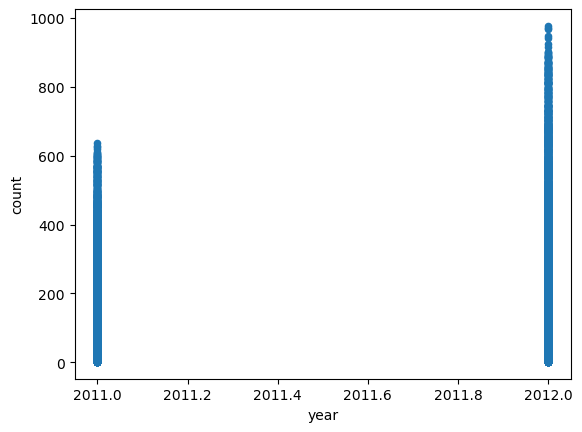

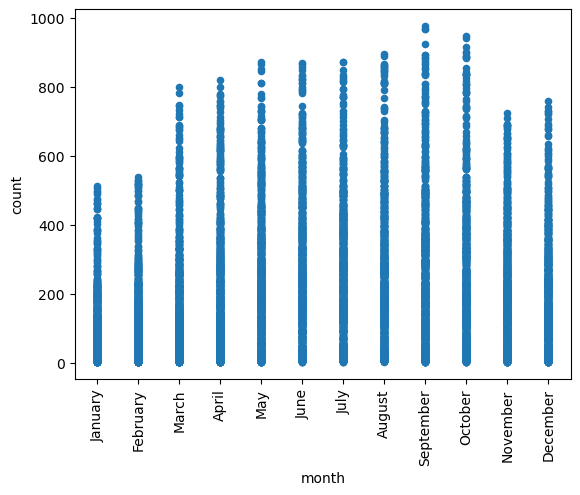

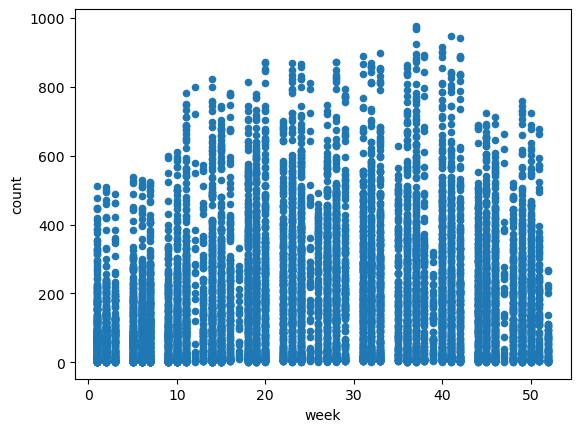

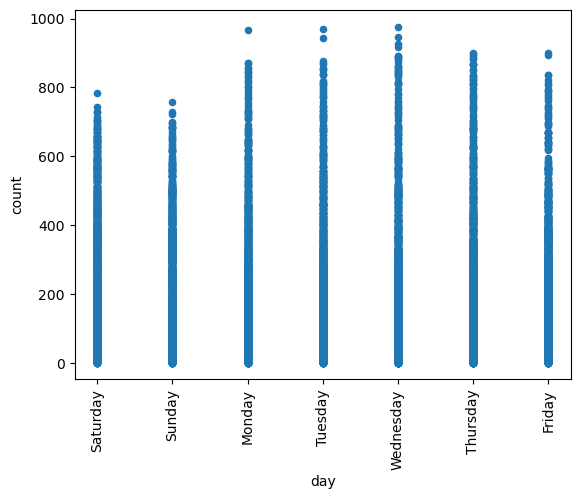

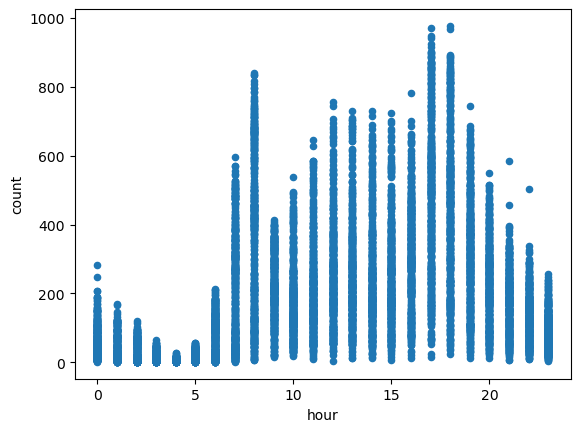

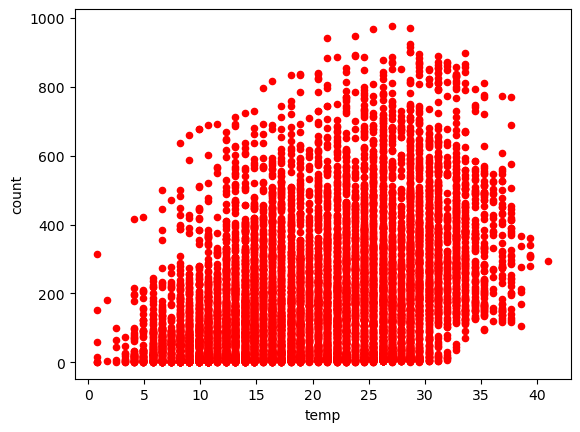

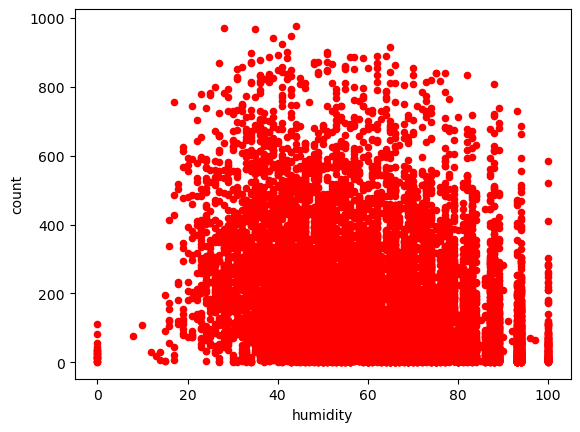

In [228]:
###Checking how datetime and atmospheric variables (temperature and humidity) impact on the 
#number of bicycles rented
df.plot.scatter(x='year', y ='count')
df.plot.scatter(x='month', y ='count', rot =90)
df.plot.scatter(x='week', y ='count')
df.plot.scatter(x='day', y ='count', rot = 90)
df.plot.scatter(x='hour', y ='count')
df.plot.scatter(x='temp', y ='count', c='red')
df.plot.scatter(x='humidity', y ='count', c='red');

In [229]:
#Bike sharing habits of casual and registered users
reg_month = df[['registered','month']].groupby('month').mean()
cas_month = df[['casual','month']].groupby('month').mean()
reg_week = df[['registered','week']].groupby('week').mean()
cas_week = df[['casual','week']].groupby('week').mean()
reg_day = df[['registered','day']].groupby('day').mean()
cas_day = df[['casual','day']].groupby('day').mean()
reg_hour = df[['registered','hour']].groupby('hour').mean()
cas_hour = df[['casual','hour']].groupby('hour').mean()

month_habit = reg_month.merge(cas_month, left_index=True, right_index = True)
week_habit = reg_week.merge(cas_week, left_index=True, right_index = True)
day_habit = reg_day.merge(cas_day, left_index=True, right_index = True)
hour_habit = reg_hour.merge(cas_hour, left_index=True, right_index = True)

print(month_habit)
print(week_habit)
print(day_habit)
print(hour_habit)


           registered     casual
month                           
April      140.361936  43.798680
August     183.822368  50.296053
December   159.495614  16.118421
February    99.684795  10.318535
January     82.162896   8.203620
July       179.462719  55.862939
June       188.770833  53.260965
March      120.360710  27.809101
May        174.190789  45.268640
November   165.847420  27.829857
October    185.891328  41.807903
September  183.309131  50.496150
      registered     casual
week                       
1      85.310030   9.762918
2      82.381818   6.378788
3      93.811688   5.110390
5      95.072797   8.536398
6      94.621212   6.930303
7     108.958065  15.425806
9      93.192469  15.464435
10    112.318182  21.712121
11    142.649351  42.899351
12    215.458333  40.916667
13     89.229167  54.197917
14    135.964179  48.414925
15    141.637725  41.715569
16    181.722222  30.958333
17     92.208333  47.416667
18    171.253205  44.903846
19    175.181548  45.488095
20    

A few considerations about the data.
- In the two years examined, the bike sharing system experiences a growth of about 30%.
- During the coldest winter months (January and February) the bikesharing system is used less.
- Weekly trend: working days see an increased use of the bikesharing system compared to weekends. 
- Hourly trend: There are evident fluctuations with minimal use of the bikesharing system during the night (ca. 11pm-6am) and peaks at 8am and 5-6 pm. Averages for the counts are listed above for each hour.
- Atmospheric variables (temperature and humidity). Atmospheric variables have a less clearly defined relationship to the counts. As expected, the vehicles of the bike sharing system are less used when the temperatures are too low (<10°C) or too high(>35°C) and when the relative humidity values are extreme (<30% or >90%), which is also an indication of the overall weather conditions (very low relative humidity = very cold, very high relative humidity = rain). The relationship existing between counts, temperature, and humidity variables is however hardly linear.
- The distribution of registered and casual users according to month/day/hour is in line with what expected, i.e. casual users are mostly to be found in warm months (June to September), at weekends, and in the afternoon. 


## Feature engineering

In [230]:
#Encoding in numerical format the information available on month and day 
#in order to include it in the correlation matrix
months = df['month'].unique().tolist()
months_numb = [x for x in range(1,13)]
months_dict = dict(zip(months, months_numb))
df['month'].replace(months_dict, inplace=True)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_numb = [x for x in range(0,7)]
days_dict = dict(zip(days, days_numb))
df['day'].replace(days_dict, inplace=True)




In [231]:
df.head(3)

,year,month,week,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011,1,52,5,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,2011,1,52,5,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,2011,1,52,5,2,1,0,0,1,9.02,13.635,80,0.0,5,27,32


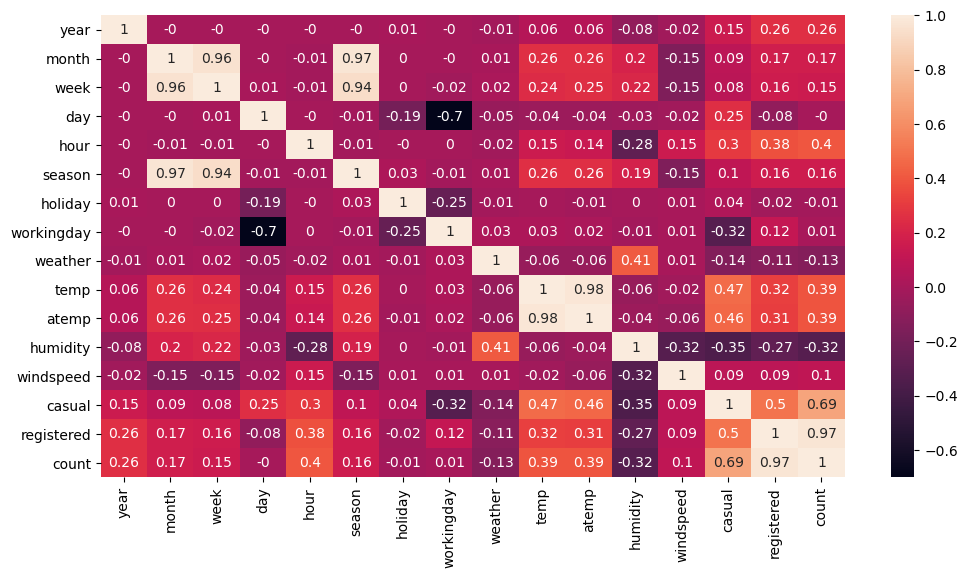

In [24]:
#Heatmap (representing the correlation matrix) of the data features
plt.rcParams['figure.figsize'] = (12,6)

sns.heatmap(round(df.corr(), 2), annot=True);

The heatmap suggests that the target, i.e. the count column is actually correlated to the weather conditions and that the interesting features are temp (positive correlation) and humidity (negative correlation). In my model I will consider as features the date-time information (year, month, week, day, hour, and holiday) and the weather information (temp, humidity).

In [232]:
#I start selecting the train dataset (i.e. dropping the target column, count, 
#and the registered and casual columns of which count is the sum.
X_train = df.drop(['casual', 'registered', 'count'], axis=1)
y_train = df['count']


In [233]:
X_train.head(3)

,year,month,week,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011,1,52,5,0,1,0,0,1,9.84,14.395,81,0.0
2011-01-01 01:00:00,2011,1,52,5,1,1,0,0,1,9.02,13.635,80,0.0
2011-01-01 02:00:00,2011,1,52,5,2,1,0,0,1,9.02,13.635,80,0.0


In [234]:
print("Min temp: ", X_train['temp'].min())
print("Max temp: ", X_train['temp'].max())
print("Min humidity: ", X_train['humidity'].min())
print("Max humidity: ", X_train['humidity'].max())
print("Min count: ", y_train.min())
print("Max count: ", y_train.max())

Min temp:  0.82
Max temp:  41.0
Min humidity:  0
Max humidity:  100
Min count:  1
Max count:  977


Temperature, humidity and count values are spread in a quite large, but positive interval. In order to improve the model predictions and to avoid that linear regression will generate negative predictions (for small values), I log transform (with a +1 shift, as log(0) is not defined) temperature, humidity and counts.

In [235]:
#Column transformer to encode year, month, week, day, hour, holiday 
#and rescale temperature and humidity using a natural logarithm (input shifted of 1) with
# the function numpy.log1p(x)


trans = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     ['year','month', 'day', 'hour']),
    ('ln scale', FunctionTransformer(np.log1p, validate=True), ['temp', 'humidity']),
     ])

In [236]:
#fitting the transformer
trans.fit(X_train, y_train)

ColumnTransformer(transformers=[('one_hot_enc',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['year', 'month', 'day', 'hour']),
                                ('ln scale',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['temp', 'humidity'])])

In [237]:
#transformed set of value to feed into the model
X_train_trans = trans.transform(X_train)

In [238]:
X_train_trans.shape

(10886, 47)

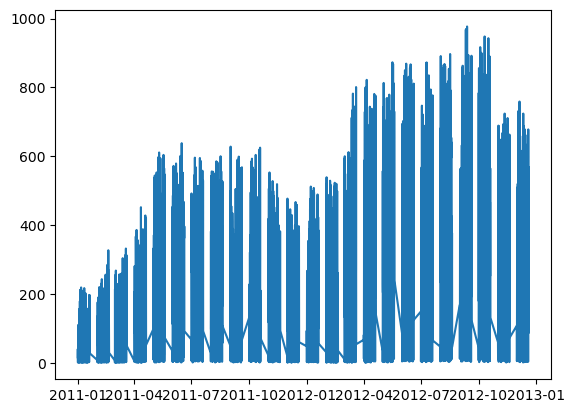

In [240]:
#ln transform of y_train
y_train_ln = np.log1p(y_train)
plt.plot(df.index, y_train);


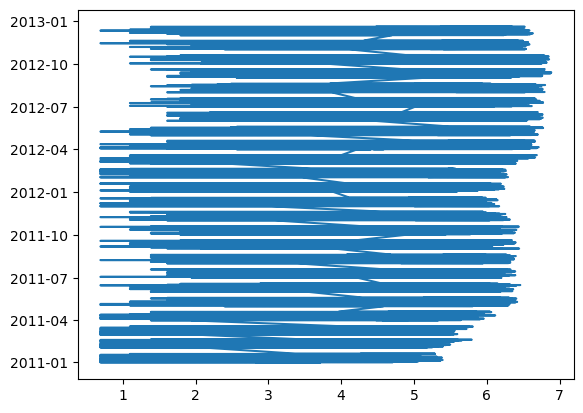

In [241]:
# plot for my presentation
plt.plot(y_train_ln, df.index);

In [242]:
y_train_ln.shape

(10886,)

## Linear regression

In [243]:
model_lr = LinearRegression()

In [244]:
model_lr.fit(X_train_trans, y_train_ln)

LinearRegression()

### Cross validation for linear regression

In [245]:
cross_validation = cross_validate(model_lr,
              X_train_trans,
              y_train_ln,
              cv=5,
              return_train_score=True)

In [246]:
cross_validation

{'fit_time': array([0.02487779, 0.0147779 , 0.0418849 , 0.03112388, 0.02853417]),
 'score_time': array([0.00685525, 0.0009799 , 0.00100613, 0.00513911, 0.00176597]),
 'test_score': array([0.71411592, 0.7889585 , 0.77751544, 0.8166404 , 0.81839259]),
 'train_score': array([0.82512413, 0.82482223, 0.82818825, 0.81455833, 0.81716212])}

In [247]:
cross_validation['train_score'].mean()

0.8219710119348556

In [248]:
#slight overfitting of the model
cross_validation['test_score'].mean()

0.7831245713293822

In [249]:
model_lr.score(X_train_trans, y_train_ln)

0.8205361305061674

## Kaggle submission for linear regression with log transformation

In [252]:
test = './kaggle_data/test.csv'
df_data = pd.read_csv(test, parse_dates=True, index_col=0)

In [253]:
df_data.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [254]:
df_data['year'] = df_data.index.year
df_data['month'] = df_data.index.month_name()
df_data['week'] = df_data.index.week
df_data['day'] = df_data.index.day_name()
df_data['hour'] = df_data.index.hour


/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [255]:
cols_data = df_data.columns.to_list()
cols_ord = cols_data[-5:] + cols_data[:-5]
df_data = df_data[cols_ord]


In [256]:
df_data.head(3)

,year,month,week,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,2011,January,3,Thursday,0,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,2011,January,3,Thursday,1,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,2011,January,3,Thursday,2,1,0,1,1,10.66,13.635,56,0.0000


In [257]:
months = df_data['month'].unique().tolist()
months_numb = [x for x in range(1,13)]
months_dict = dict(zip(months, months_numb))
df_data['month'].replace(months_dict, inplace=True)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_numb = [x for x in range(0,7)]
days_dict = dict(zip(days, days_numb))
df_data['day'].replace(days_dict, inplace=True)

In [258]:
df_data.dtypes


year            int64
month           int64
week            int64
day             int64
hour            int64
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [259]:
X_test_transform = trans.transform(df_data)



In [260]:
X_test_transform.shape


(6493, 47)

In [261]:
ypred_lr_ln = model_lr.predict(X_test_transform)

print(ypred_lr_ln)

[2.76367188 2.16601562 1.70507812 ... 5.15820312 4.91992188 4.484375  ]


In [53]:
ypred_lr = np.expm1(ypred_lr_ln)


print(ypred_lr)

[ 14.85796464   7.72345718   4.50181548 ... 172.85178485 135.99191028
  87.62154503]


In [262]:
submission_lr = pd.DataFrame(ypred_lr, index=df_data.index, columns=['count'])
submission_lr.to_csv('submission_lr_bikesharing.csv')

## Results without log transformation

In [263]:
trans_no_log = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     ['year', 'month', 'day', 'hour']),
    ('scale', MinMaxScaler(), ['temp', 'humidity']),
     ])

In [264]:
trans_no_log.fit(X_train, y_train)
X_train_trans_no_log = trans_no_log.transform(X_train)
model_lr_no_log = LinearRegression()
model_lr_no_log.fit(X_train_trans_no_log, y_train)
model_lr_no_log.score(X_train_trans, y_train)

0.3223078016425972

In [265]:
X_test_transform_no_log = trans_no_log.transform(df_data)
print(X_test_transform_no_log.shape)

(6493, 47)


In [266]:
ypred_lr_no_log = model_lr_no_log.predict(X_test_transform_no_log)
print(ypred_lr_no_log.shape)


(6493,)


In [267]:
submission_lr_no_log = pd.DataFrame(ypred_lr_no_log, index=df_data.index, columns=['count'])
submission_lr_no_log.to_csv('no_log_submission_lr_bikesharing.csv')

## Random forest regressor

Through repeated applications of the random forest regressor it became evident that the best results are obtained without the use of the column transformer. The model will therefore be applied to the X_train data not transformed.

In [268]:
model_rfr = RandomForestRegressor(max_depth =20, random_state=0)


In [269]:
model_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, random_state=0)

In [270]:
cross_validation_rfr = cross_validate(model_rfr,
              X_train,
              y_train,
              cv=5,
              return_train_score=True)

In [63]:
cross_validation_rfr['train_score'].mean()

0.9930409377074969

In [64]:
# overfitting
cross_validation_rfr['test_score'].mean()

0.7005641517881037

In [272]:
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth' : [None, 5, 10, 20],
              'min_samples_split' : [2, 3, 5]}

In [273]:
rfr_opti = RandomForestRegressor()

In [274]:
gridsearch = GridSearchCV(rfr_opti, param_grid, verbose=True)

In [275]:
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.6min finished


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [10, 50, 100]},
             verbose=True)

In [276]:
gridsearch.best_params_


{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

In [277]:
gridsearch.best_score_

0.7045244642254409

In [279]:
results = pd.DataFrame(gridsearch.cv_results_)

In [280]:
model_opt_rfr = RandomForestRegressor(n_estimators = 50, max_depth =None, min_samples_split=5)

In [281]:
model_opt_rfr.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=50)

In [282]:
cross_validation_opt_rfr = cross_validate(model_opt_rfr,
              X_train,
              y_train,
              cv=5,
              return_train_score=True)

In [283]:
cross_validation_opt_rfr['train_score'].mean()

0.9876972949697429

In [284]:
cross_validation_opt_rfr['test_score'].mean()

0.7008666255928097

In [285]:
ypred_opt_rfr = model_opt_rfr.predict(df_data)

print(ypred_opt_rfr)

[ 11.22467244   5.60969048   4.43366667 ... 116.1035873   97.24902381
  59.05621429]


In [286]:
#Although the computed cross validation test score is theoretically less than the one computed 
#for linear regression, the random forest regressor model achieves a better Kaggle score.
submission_opt_rfr = pd.DataFrame(ypred_opt_rfr, index=df_data.index, columns=['count'])
submission_opt_rfr.to_csv('submission_opt_rfr_bikesharing.csv')

## Poisson regression

In [287]:
model_poisson = linear_model.PoissonRegressor(max_iter = 300)

In [288]:
model_poisson.fit(X_train_trans_no_log, y_train)

PoissonRegressor(max_iter=300)

In [289]:
cross_validation_poisson = cross_validate(model_poisson,
              X_train_trans_no_log,
              y_train,
              cv=5,
              return_train_score=True)

In [290]:
cross_validation_poisson['train_score'].mean()

0.7641150138543407

In [291]:
cross_validation['test_score'].mean()

0.7831245713293822

In [292]:
ypred_poisson = model_poisson.predict(X_test_transform_no_log)

print(ypred_poisson)

[ 30.02511923  23.83240706  20.81572736 ... 187.29041637 156.33674983
 110.14823978]


In [293]:
param_grid_poisson = {'alpha': [0.2, 0.5, 0.7],
              'max_iter' : [100, 200, 300]
             }

In [294]:
model_opt_poisson = linear_model.PoissonRegressor(max_iter = 300)

In [295]:
gridsearch_poisson = GridSearchCV(model_opt_poisson, param_grid_poisson, verbose=True)

In [296]:
gridsearch_poisson.fit(X_train_trans_no_log, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.2s finished


GridSearchCV(estimator=PoissonRegressor(max_iter=300),
             param_grid={'alpha': [0.2, 0.5, 0.7], 'max_iter': [100, 200, 300]},
             verbose=True)

In [297]:
gridsearch_poisson.best_params_

{'alpha': 0.2, 'max_iter': 200}

In [298]:
gridsearch.best_score_

0.7045244642254409

In [299]:
model_poisson_opt = linear_model.PoissonRegressor(alpha= 0.2, max_iter= 200)

In [300]:
model_poisson_opt.fit(X_train_trans_no_log, y_train)

PoissonRegressor(alpha=0.2, max_iter=200)

In [301]:
ypred_poisson_opt = model_poisson_opt.predict(X_test_transform_no_log)

In [302]:
submission_poisson = pd.DataFrame(ypred_poisson_opt, index=df_data.index, columns=['count'])
submission_poisson.to_csv('submission_poisson_bikesharing.csv')

## Polynomial Regression


In [303]:
poly_pipeline = make_pipeline(
                    FunctionTransformer(np.log1p, validate=True),
                    PolynomialFeatures(degree=2, include_bias=False)
                )

trans_poly = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     ['year','month', 'day', 'hour']),
    ('polytransf', poly_pipeline, ['temp']),
     ])

In [305]:
trans_poly.fit(X_train, y_train_ln)

ColumnTransformer(transformers=[('one_hot_enc',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['year', 'month', 'day', 'hour']),
                                ('polytransf',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['temp'])])

In [306]:
X_train_trans_poly = trans_poly.transform(X_train)

In [307]:
model_lr_poly = LinearRegression()

In [308]:
model_lr_poly.fit(X_train_trans_poly, y_train_ln)

LinearRegression()

In [309]:
model_lr_poly.score(X_train_trans_poly, y_train_ln)

0.815992322080334

In [310]:
X_test_transform_poly = trans_poly.transform(df_data)

In [311]:
ypred_lr_poly = model_lr_poly.predict(X_test_transform_poly)


In [312]:
ypred_lr_poly_transf = np.expm1(ypred_lr_poly)

In [313]:
submission_lr_poly = pd.DataFrame(ypred_lr_poly_transf, index=df_data.index, columns=['count'])
submission_lr_poly.to_csv('submission_lr_poly_bikesharing.csv')